In [ ]:
!pip install pybit


In [ ]:
!pip uninstall six -y
!pip install six


In [ ]:
!pip uninstall urllib3 -y
!pip install urllib3


In [ ]:
!pip install requests


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
 
from func_get_symbols import get_tradeable_symbols 
from func_prices_json import store_price_history
from func_cointegration import extract_close_prices
from func_cointegration import get_cointegrated_pairs
from func_cointegration import enhanced_cointegration
from func_plot_trends import plot_trends
import pandas as pd
import json
# Add new imports
from func_clustering import cluster_symbols
from func_pca_analysis import static_pca, rolling_pca
# Add new imports for Dask and parallel processing
import dask.dataframe as dd
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import os
import time


# --- Parallelized Cointegration Testing ---
def process_cointegration_in_batches(pairs, data, batch_size=100):
    """Process cointegration testing in batches with saving and progress tracking."""
    results = []
    num_batches = len(pairs) // batch_size + 1
    start_time = time.time()  # Track start time
    
    # Define save path for intermediate results
    save_path = "cointegration_results"
    os.makedirs(save_path, exist_ok=True)
    
    for batch_idx in range(num_batches):
        # Skip processing if the batch file already exists
        file_name = f"cointegration_results_batch_{batch_idx}.csv"
        file_path = os.path.join(save_path, file_name)
        if os.path.exists(file_path):
            print(f"Batch {batch_idx} already processed. Skipping...")
            continue
        
        # Process the batch
        batch_pairs = pairs[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        tasks = [
            delayed(enhanced_cointegration)(data[pair[0]], data[pair[1]])
            for pair in batch_pairs
        ]
        
        # Compute the tasks in parallel
        with ProgressBar():
            batch_results = compute(*tasks)
        
        # Filter valid results
        batch_results = [
            {"pair": f"{pair[0]}-{pair[1]}", **result}
            for pair, result in zip(batch_pairs, batch_results)
            if result is not None and all([
                result['eg_pvalue'] < 0.05,
                result['adf_pvalue'] < 0.05,
                result['hurst'] < 0.5,
                result['half_life'] < 20  # New criterion: half-life less than 20 periods
            ])
        ]
        results.extend(batch_results)
        
        # Save batch results to CSV
        if batch_results:
            batch_results_df = pd.DataFrame(batch_results)
            batch_results_df.to_csv(file_path, index=False)
            print(f"Batch {batch_idx} file saved as CSV: {file_path}")
        
        # Time tracking and progress
        elapsed_time = time.time() - start_time
        remaining_batches = num_batches - (batch_idx + 1)
        estimated_time_remaining = (elapsed_time / (batch_idx + 1)) * remaining_batches
        print(f"Batch {batch_idx + 1}/{num_batches} completed.")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds")
        print(f"Estimated Time Remaining: {estimated_time_remaining:.2f} seconds")
    
    return results



if __name__ == "__main__":
    # STEP 1 - Get liquid symbols
    print("Filtering liquid symbols...")
    symbols = get_tradeable_symbols()
    
    # STEP 2 - Get price history
    print("Fetching price data...")
    store_price_history(symbols)
    
    # STEP 3 - Load price data and process close prices
    with open("1_price_list.json") as f:
        raw_price_data = json.load(f)
    
    # Extract close prices for each symbol
    close_prices = {}
    for symbol, klines in raw_price_data.items():
        closes = extract_close_prices(klines)
        if len(closes) > 0:
            close_prices[symbol] = closes
    
    # Create DataFrame of close prices
    price_df = pd.DataFrame(close_prices)
    
    # STEP 4 - Cluster symbols using close prices
    print("Clustering symbols...")
    clusters = cluster_symbols(price_df)
    
    # STEP 5 - PCA analysis
    print("Performing PCA analysis...")
    for cluster_id in clusters.unique():
        cluster_symbols = clusters[clusters == cluster_id].index.tolist()
        cluster_prices = pd.DataFrame({sym: price_df[sym] for sym in cluster_symbols})
        static_components = static_pca(cluster_prices)
        rolling_components = rolling_pca(cluster_prices)
    
    # STEP 6 - Enhanced cointegration testing in batches
    print("Running advanced cointegration tests in batches...")
    all_pairs = []
    for cluster_id in clusters.unique():
        cluster_symbols = clusters[clusters == cluster_id].index.tolist()
        # Generate all unique pairs within the cluster
        pairs = [(cluster_symbols[i], cluster_symbols[j]) 
                 for i in range(len(cluster_symbols)) 
                 for j in range(i + 1, len(cluster_symbols))]
        all_pairs.extend(pairs)
    
    # Process cointegration in batches
    cointegrated_pairs = process_cointegration_in_batches(all_pairs, price_df)
    
    # STEP 7 - Ranking and final selection
    print("Ranking pairs...")
    df_pairs = pd.DataFrame(cointegrated_pairs)
    df_pairs['liquidity_score'] = df_pairs['pair'].apply(
        lambda x: (price_df[x.split('-')[0]].mean() + price_df[x.split('-')[1]].mean()) / 2
    )
    df_pairs['final_score'] = (
        0.3 * (1 - df_pairs['composite_score']) +
        0.2 * df_pairs['liquidity_score'] +
        0.2 * (1 - df_pairs['hurst']) +
        0.3 * (1 / df_pairs['half_life'])  # Higher weight for shorter half-life
    )
    df_pairs.sort_values('final_score', ascending=False, inplace=True)
    df_pairs.to_csv("professional_pairs.csv", index=False)
    print("Final ranked pairs saved to 'professional_pairs.csv'.")

Filtering liquid symbols...
Fetching price data...
Clustering symbols...


C:\Users\abc\anaconda3\New folder\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\abc\anaconda3\New folder\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\abc\anaconda3\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\abc\anaconda3\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a

Performing PCA analysis...
Running advanced cointegration tests in batches...
[########################################] | 100% Completed | 134.03 s
Batch 1/462 completed.
Elapsed Time: 141.70 seconds
Estimated Time Remaining: 65323.39 seconds
[########################################] | 100% Completed | 137.86 s
Batch 2/462 completed.
Elapsed Time: 279.64 seconds
Estimated Time Remaining: 64316.52 seconds
[########################################] | 100% Completed | 136.31 s
Batch 3/462 completed.
Elapsed Time: 416.02 seconds
Estimated Time Remaining: 63651.35 seconds
[########################################] | 100% Completed | 137.61 s
Batch 4/462 completed.
Elapsed Time: 553.71 seconds
Estimated Time Remaining: 63399.97 seconds
[########################################] | 100% Completed | 136.96 s
Batch 4 file saved as CSV: cointegration_results\cointegration_results_batch_4.csv
Batch 5/462 completed.
Elapsed Time: 690.86 seconds
Estimated Time Remaining: 63144.87 seconds
[########

Plotting trends...
File for backtesting saved.


C:\Users\abc\Desktop\model_in_progress\stat arb mine\strat mine\func_plot_trends.py:444: UserWarning: The following kwargs were not used by contour: 'label'
  ax5.contour(X, Y, Z, levels=[threshold], colors="red", linestyles="--", label="95% Boundary")


Latest data point is INSIDE the copula boundary. No trading opportunity at present.


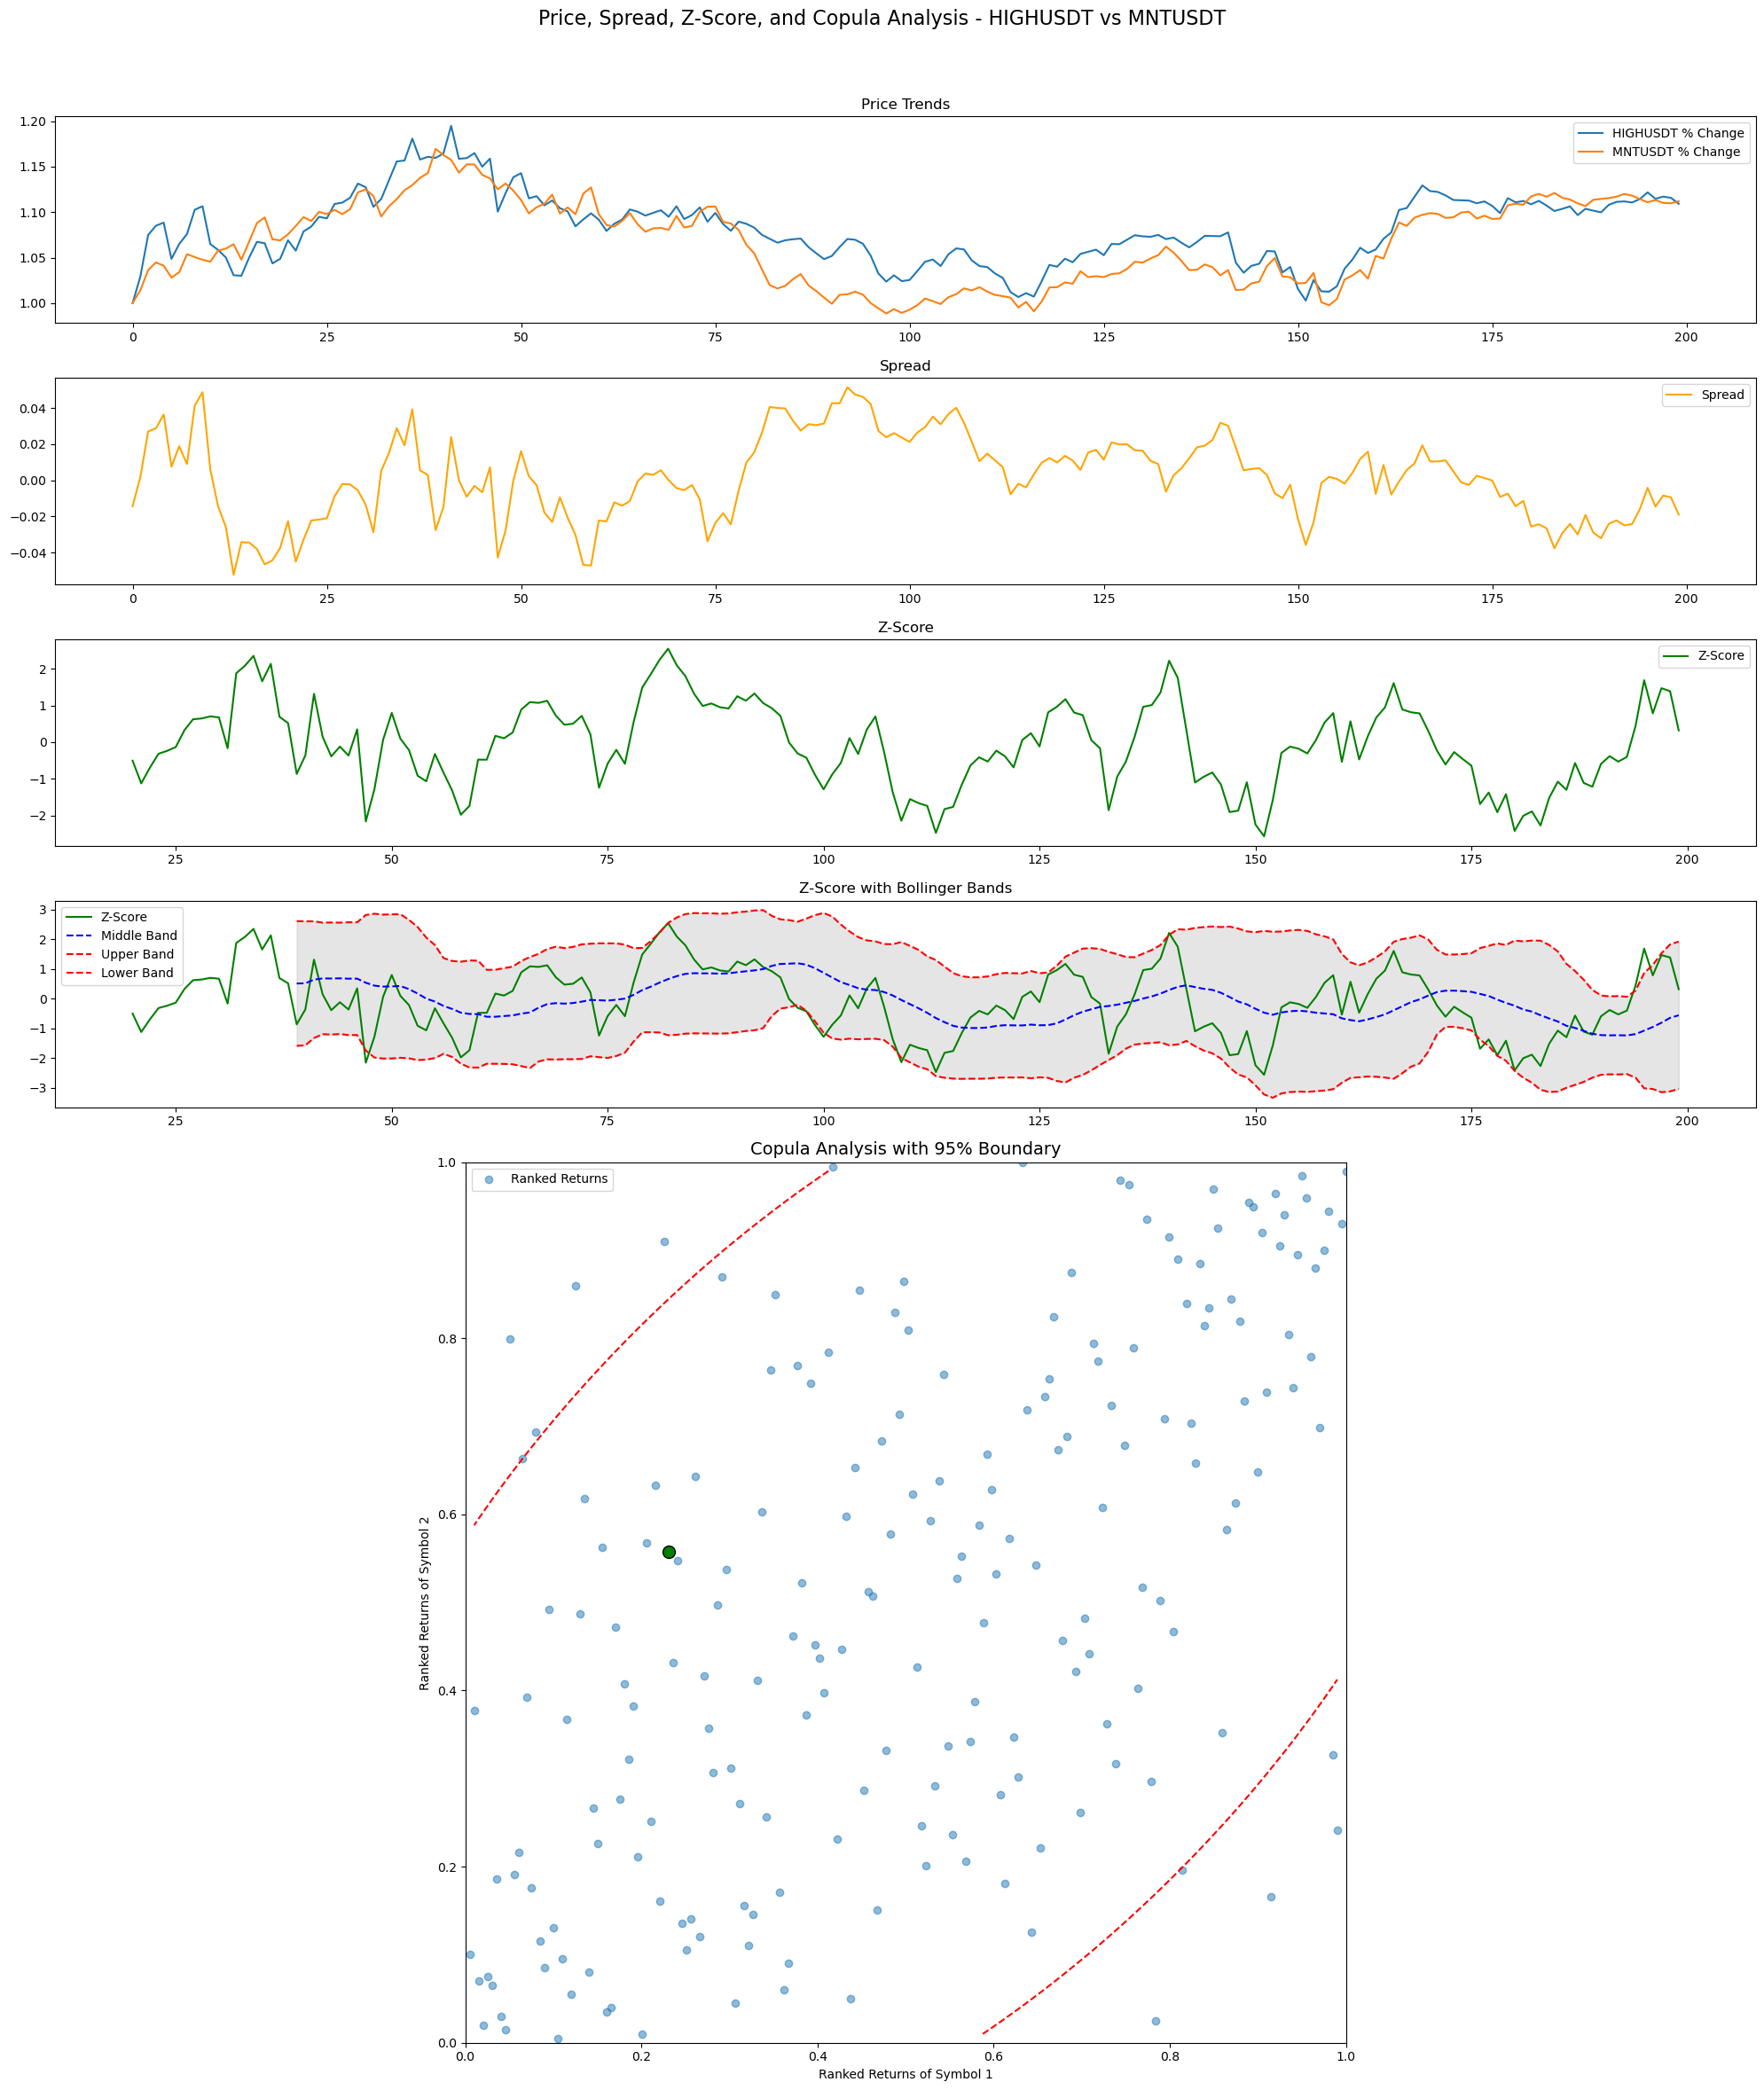

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
 
from func_get_symbols import get_tradeable_symbols 
from func_prices_json import store_price_history
from func_cointegration import extract_close_prices
from func_cointegration import get_cointegrated_pairs
from func_cointegration import enhanced_cointegration
from func_plot_trends import plot_trends
import pandas as pd
import json
 
if __name__ == "__main__":
 
    # STEP 4 - Plot trends and save for backtesting
    print("Plotting trends...")
    symbol_1 = "HIGHUSDT"
    symbol_2 = "MNTUSDT"
    with open("1_price_list.json") as json_file:
        price_data = json.load(json_file)
        if len(price_data) > 0:
            plot_trends(symbol_1, symbol_2, price_data)


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from func_get_symbols import get_tradeable_symbols
from func_prices_json import store_price_history
from func_cointegration import extract_close_prices, enhanced_cointegration
from func_plot_trends import plot_trends
from func_clustering import cluster_symbols, dbscan_clustering, calculate_metrics
from func_pca_analysis import static_pca, rolling_pca
from func_graph_analysis import build_graph, detect_communities
from func_reinforcement_learning import train_rl_agent, rank_pairs_with_rl
from func_liquidity_filter import filter_liquid_symbols
# from func_price_klines import get_extended_price_klines
from func_autoencoder import train_autoencoder
from func_copulas import select_best_copula
from func_portfolio_optimization import mean_variance_optimization
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import json
import os
import time

# --- Helper Functions ---
def fit_garch(spread):
    """Fit GARCH(1,1) model to the spread."""
    try:
        model = arch_model(spread, vol='Garch', p=1, q=1)
        res = model.fit(disp="off")
        return res.conditional_volatility
    except Exception as e:
        print(f"GARCH fitting error: {str(e)}")
        return None

def refine_pairs_with_communities(cointegrated_pairs, communities):
    """Refine pairs based on community detection results."""
    refined_pairs = []
    community_counts = {}
    
    for pair in cointegrated_pairs:
        sym_1, sym_2 = pair['pair'].split('-')
        community_1 = communities.get(sym_1)
        community_2 = communities.get(sym_2)
        
        if community_1 == community_2:
            community_counts[community_1] = community_counts.get(community_1, 0) + 1
            if community_counts[community_1] <= 5:  # Limit to top 5 pairs per community
                refined_pairs.append(pair)  # Preserve the entire pair dictionary
    
    return refined_pairs


def calculate_features(spread):
    """Extract statistical features from the spread."""
    mean = np.mean(spread)
    std_dev = np.std(spread)
    skewness = pd.Series(spread).skew()
    kurtosis = pd.Series(spread).kurt()
    return {'mean': mean, 'std_dev': std_dev, 'skewness': skewness, 'kurtosis': kurtosis}


def process_cointegration_in_batches(pairs, price_data, batch_size=100):
    """
    Process cointegration testing in batches with saving and progress tracking.
    """
    results = []
    num_batches = len(pairs) // batch_size + 1
    save_path = "cointegration_results"
    os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists
    start_time = time.time()  # Track start time for progress estimation

    for batch_idx in range(num_batches):
        # Define the file name for this batch
        file_name = f"cointegration_results_batch_adv_{batch_idx}.csv"
        file_path = os.path.join(save_path, file_name)

        # Skip processing if the batch file already exists
        if os.path.exists(file_path):
            print(f"Batch {batch_idx} already processed. Skipping...")
            continue

        # Process the current batch
        batch_pairs = pairs[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        batch_results = []

        for pair in batch_pairs:
            try:
                sym_1, sym_2 = pair
                series_1 = price_data[sym_1]
                series_2 = price_data[sym_2]

                # Perform enhanced cointegration testing
                result = enhanced_cointegration(series_1, series_2)

                # Filter valid results based on criteria
                if result is not None and all([
                    result['eg_pvalue'] < 0.05,
                    result['adf_pvalue'] < 0.05,
                    result['hurst'] < 0.5,
                    'half_life' in result and result['half_life'] < 20  # Ensure half-life is included
                ]):
                    batch_results.append({"pair": f"{sym_1}-{sym_2}", **result})
            except Exception as e:
                print(f"Error processing pair {pair}: {str(e)}")
                continue

        # Extend the main results list with this batch's results
        results.extend(batch_results)

        # Save batch results to CSV
        if batch_results:
            batch_results_df = pd.DataFrame(batch_results)
            batch_results_df.to_csv(file_path, index=False)
            print(f"Batch {batch_idx} file saved as CSV: {file_path}")

        # Track progress and estimate remaining time
        elapsed_time = time.time() - start_time
        remaining_batches = num_batches - (batch_idx + 1)
        estimated_time_remaining = (elapsed_time / (batch_idx + 1)) * remaining_batches

        print(f"Batch {batch_idx + 1}/{num_batches} completed.")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds")
        print(f"Estimated Time Remaining: {estimated_time_remaining:.2f} seconds")

    return results


# --- Main Workflow ---
if __name__ == "__main__":
    # STEP 1 - Get liquid symbols
    print("Filtering liquid symbols...")
    symbols = get_tradeable_symbols()
    
    # STEP 2 - Get price history
    print("Fetching price data...")
    store_price_history(symbols)
    
    # STEP 3 - Load price data and process close prices
    with open("1_price_list.json") as f:
        raw_price_data = json.load(f)
    
    # Extract close prices for each symbol
    close_prices = {}
    for symbol, klines in raw_price_data.items():
        closes = extract_close_prices(klines)
        if len(closes) > 0 and not any(np.isnan(closes)):  # Ensure no NaN values
            close_prices[symbol] = closes
        else:
            print(f"No valid close prices found for {symbol}. Skipping...")

    # Create DataFrame of close prices
    price_df = pd.DataFrame(close_prices)

    # STEP 4 - Calculate Returns and Volatility from Raw Data
    returns, volatility = calculate_metrics(price_df)
    features_raw = pd.DataFrame({'Returns': returns, 'Volatility': volatility}).dropna()

    # Drop columns with all NaN values
    price_df = price_df.dropna(axis=1, how="all")

    # Fill remaining NaN values with the mean of the column
    price_df = price_df.fillna(price_df.mean())

    # Ensure price_df is not empty after preprocessing
    if price_df.empty:
        raise ValueError("Price DataFrame is empty after preprocessing. Please check the input data.")

    # STEP 4 - Apply Autoencoder
    print("Training autoencoder for feature extraction...")

    # Validate price_df
    if price_df.empty:
        raise ValueError("Price DataFrame is empty. Please check the input data.")

    # Drop columns with all NaN values
    price_df = price_df.dropna(axis=1, how="all")

    # Fill remaining NaN values with the mean of the column
    price_df = price_df.fillna(price_df.mean())

    # Transpose the DataFrame
    price_df_t = price_df.T

    # Validate transposed DataFrame
    if price_df_t.empty:
        raise ValueError("Transposed price DataFrame is empty after preprocessing. Please check the input data.")

    # Train the autoencoder
    autoencoder_features = train_autoencoder(price_df_t, encoding_dim=3)

    
    # STEP 5 - Apply PCA to all symbols
    print("Performing PCA analysis on all symbols...")
    static_components = static_pca(price_df)
    rolling_components = rolling_pca(price_df)

    # Combine autoencoder features with PCA features
    pca_feature_static = static_components[0]
    pca_feature_rolling = rolling_components.mean(axis=0)[0]
    combined_features = pd.concat([
        autoencoder_features,
        features_raw,
        pd.DataFrame({"PCA_Feature_Static": pca_feature_static, "PCA_Feature_Rolling": pca_feature_rolling}, index=price_df.columns)
    ], axis=1)

    # STEP 6 - Cluster symbols using KMeans with combined features
    print("Clustering symbols using combined features...")
    clusters_kmeans = cluster_symbols(combined_features)
    clusters_dbscan = dbscan_clustering(combined_features)
    

    # STEP 7 - Enhanced cointegration testing for both KMeans and DBSCAN clusters
    print("Running advanced cointegration tests in batches...")
    def generate_pairs_from_clusters(clusters):
        all_pairs = []
        for cluster_id in clusters.unique():
            cluster_symbols = clusters[clusters == cluster_id].index.tolist()
            pairs = [(cluster_symbols[i], cluster_symbols[j]) 
                     for i in range(len(cluster_symbols)) 
                     for j in range(i + 1, len(cluster_symbols))]
            all_pairs.extend(pairs)
        return all_pairs

    kmeans_pairs = generate_pairs_from_clusters(clusters_kmeans)
    dbscan_pairs = generate_pairs_from_clusters(clusters_dbscan)


    # Process cointegration in batches
    cointegrated_kmeans_pairs = process_cointegration_in_batches(kmeans_pairs, price_df)
    cointegrated_dbscan_pairs = process_cointegration_in_batches(dbscan_pairs, price_df)

    # Combine results from both clustering methods
    cointegrated_pairs = cointegrated_kmeans_pairs + cointegrated_dbscan_pairs

    # STEP 8 - Detect communities of cointegrated assets
    print("Detecting communities...")
    G = build_graph(cointegrated_pairs)
    communities = detect_communities(G)

    # Refine pairs based on communities
    refined_pairs = refine_pairs_with_communities(cointegrated_pairs, communities)

    # STEP 9 - Train RL agent for dynamic pair selection
    print("Training RL agent for pair selection...")
    rl_model = train_rl_agent(pd.DataFrame(refined_pairs))

    # Rank pairs using RL agent
    ranked_pairs = rank_pairs_with_rl(refined_pairs, rl_model)

    # Add Copula Metrics
    print("Calculating copula metrics...")
    for pair in ranked_pairs:
        sym_1, sym_2 = pair['pair'].split('-')
        returns_1 = price_df[sym_1].pct_change().dropna()
        returns_2 = price_df[sym_2].pct_change().dropna()
        u = returns_1.rank(pct=True).values
        v = returns_2.rank(pct=True).values
        
        # Select the best-fitting copula
        best_copula = select_best_copula(u, v)
        pair['copula_type'] = best_copula["type"]
        pair['copula_params'] = best_copula["params"]
        pair['copula_aic'] = best_copula["aic"]
        
        # Calculate tail dependence based on the selected copula
        if best_copula["type"] == "gaussian":
            lower_tail, upper_tail = calculate_tail_dependence(u, v, quantile=0.05)
        elif best_copula["type"] == "student_t":
            lower_tail, upper_tail = calculate_tail_dependence(u, v, quantile=0.05)
        elif best_copula["type"] == "clayton":
            lower_tail = best_copula["params"][0] / (best_copula["params"][0] + 2)
            upper_tail = 0
        elif best_copula["type"] == "gumbel":
            lower_tail = 0
            upper_tail = 2 - 2**(1 / best_copula["params"][0])
        elif best_copula["type"] == "frank":
            lower_tail = 0
            upper_tail = 0
        
        pair['lower_tail'] = lower_tail
        pair['upper_tail'] = upper_tail

    # STEP 10 - Rank pairs based on composite score
    print("Ranking pairs...")
    df_pairs = pd.DataFrame(ranked_pairs)
    df_pairs['garch_volatility'] = df_pairs['pair'].apply(
        lambda x: fit_garch(price_df[x.split('-')[0]] - price_df[x.split('-')[1]])
    )
    df_pairs['features'] = df_pairs['pair'].apply(
        lambda x: calculate_features(price_df[x.split('-')[0]] - price_df[x.split('-')[1]])
    )
    df_pairs['pca_score'] = df_pairs['pair'].apply(
        lambda x: combined_features.loc[x.split('-')[0], "PCA_Feature_Static"] + combined_features.loc[x.split('-')[1], "PCA_Feature_Static"]
    )
    df_pairs['explained_variance_ratio'] = df_pairs['pair'].apply(
        lambda x: explained_variance[0]  # First principal component's explained variance
    )
    df_pairs['final_score'] = (
        0.3 * (1 - df_pairs['composite_score']) +
        0.2 * df_pairs['liquidity_score'] +
        0.1 * (1 - df_pairs['hurst']) +
        0.1 * (1 / df_pairs['half_life']) +
        0.1 * df_pairs['garch_volatility'] +
        0.05 * df_pairs['pca_score'] +
        0.05 * df_pairs['explained_variance_ratio'] +
        0.05 * (1 - df_pairs['copula_corr']) +  # Lower correlation is better
        0.025 * (1 - df_pairs['lower_tail']) +  # Lower tail dependence is better
        0.025 * (1 - df_pairs['upper_tail']) +  # Lower tail dependence is better
        0.1 * (1 - df_pairs['rl_rank'] / len(df_pairs))  # Normalize RL rank to [0, 1]
    )
    df_pairs.sort_values('final_score', ascending=False, inplace=True)

    # STEP 11 - Mean-Variance Optimization
    print("Performing mean-variance optimization...")
    top_pairs = df_pairs.head(20)  # Select top 20 pairs for optimization
    pair_names = top_pairs['pair'].tolist()

    # Calculate expected returns and covariance matrix
    pair_returns = pd.DataFrame()
    for pair in pair_names:
        sym_1, sym_2 = pair.split('-')
        spread = price_df[sym_1] - price_df[sym_2]
        pair_returns[pair] = spread.pct_change().dropna()

    expected_returns = pair_returns.mean()
    cov_matrix = pair_returns.cov()

    # Set target return (e.g., average expected return)
    target_return = expected_returns.mean()

    # Perform optimization
    try:
        optimal_weights = mean_variance_optimization(expected_returns, cov_matrix, target_return)
    except ValueError as e:
        print(f"Optimization error: {str(e)}")
        optimal_weights = np.ones(len(pair_names)) / len(pair_names)  # Fallback to equal weights

    # Add optimal weights to the DataFrame
    top_pairs['optimal_weight'] = optimal_weights

    # Save final ranked pairs with optimal weights
    top_pairs.to_csv("optimized_pairs.csv", index=False)
    print("Optimized pairs saved to 'optimized_pairs.csv'.")

Filtering liquid symbols...
Fetching price data...
Training autoencoder for feature extraction...
Epoch [10/50], Loss: 1.2578
Epoch [20/50], Loss: 1.2535
Epoch [30/50], Loss: 1.2494
Epoch [40/50], Loss: 1.2454
Epoch [50/50], Loss: 1.2414
Performing PCA analysis on all symbols...
Clustering symbols using combined features...


C:\Users\abc\anaconda3\New folder\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\abc\anaconda3\New folder\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\abc\anaconda3\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\abc\anaconda3\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a

Running advanced cointegration tests in batches...
Batch 1/770 completed.
Elapsed Time: 135.19 seconds
Estimated Time Remaining: 103964.95 seconds


KeyboardInterrupt: 

In [ ]:
print("hi")

In [15]:
# Import necessary libraries
import networkx as nx
from func_graph_analysis import build_graph, detect_communities

# Mock cointegrated pairs for testing
mock_cointegrated_pairs = [
    {"pair": "A-B", "p_value": 0.01},
    {"pair": "B-C", "p_value": 0.02},
    {"pair": "C-D", "p_value": 0.03},
    {"pair": "A-C", "p_value": 0.04},
    {"pair": "D-E", "p_value": 0.05},
]

# Step 1: Test build_graph function
print("Testing build_graph function...")
G = build_graph(mock_cointegrated_pairs)

# Validate the graph
print("Nodes in the graph:", G.nodes)
print("Edges in the graph:", G.edges(data=True))

# Check if the graph has the correct number of nodes and edges
assert len(G.nodes) == 5, "Graph does not have the expected number of nodes!"
assert len(G.edges) == 5, "Graph does not have the expected number of edges!"

# Validate edge weights
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v} has weight: {data['weight']}")
    assert data['weight'] > 0, f"Edge {u}-{v} has invalid weight!"

print("build_graph function passed all checks!")

# Step 2: Test detect_communities function
print("\nTesting detect_communities function...")
communities = detect_communities(G)

# Validate the community detection result
print("Detected communities:", communities)

# Check if all nodes are assigned to a community
assert len(communities) == len(G.nodes), "Not all nodes are assigned to a community!"

# Print community assignments
for node, community_id in communities.items():
    print(f"Node {node} belongs to community {community_id}")

print("detect_communities function passed all checks!")


Testing build_graph function...
Nodes in the graph: ['A', 'B', 'C', 'D', 'E']
Edges in the graph: [('A', 'B', {'weight': 100.0}), ('A', 'C', {'weight': 25.0}), ('B', 'C', {'weight': 50.0}), ('C', 'D', {'weight': 33.333333333333336}), ('D', 'E', {'weight': 20.0})]
Edge A-B has weight: 100.0
Edge A-C has weight: 25.0
Edge B-C has weight: 50.0
Edge C-D has weight: 33.333333333333336
Edge D-E has weight: 20.0
build_graph function passed all checks!

Testing detect_communities function...
Detected communities: {'A': 1, 'B': 1, 'C': 0, 'D': 0, 'E': 0}
Node A belongs to community 1
Node B belongs to community 1
Node C belongs to community 0
Node D belongs to community 0
Node E belongs to community 0
detect_communities function passed all checks!


In [1]:
import pandas as pd
from func_reinforcement_learning import train_rl_agent, rank_pairs_with_rl
import numpy as np

# Mock input data
mock_cointegrated_pairs = [
    {
        "pair": "A-B",
        "composite_score": 0.8,
        "liquidity_score": 0.9,
        "hurst": 0.4,
        "half_life": 5,
        "final_score": 0.7  # Add final_score here
    },
    {
        "pair": "A-C",
        "composite_score": 0.7,
        "liquidity_score": 0.8,
        "hurst": 0.5,
        "half_life": 10,
        "final_score": 0.6  # Add final_score here
    },
    {
        "pair": "B-C",
        "composite_score": 0.6,
        "liquidity_score": 0.7,
        "hurst": 0.6,
        "half_life": 15,
        "final_score": 0.5  # Add final_score here
    }
]

mock_communities = {
    "A": 0,
    "B": 0,
    "C": 0,
    "D": 1,
    "E": 1,
}

def refine_pairs_with_communities(cointegrated_pairs, communities):
    """Refine pairs based on community detection results."""
    refined_pairs = []
    community_counts = {}
    
    # Iterate over rows of the DataFrame
    for _, row in cointegrated_pairs.iterrows():
        sym_1, sym_2 = row['pair'].split('-')
        community_1 = communities.get(sym_1)
        community_2 = communities.get(sym_2)
        
        if community_1 == community_2:
            community_counts[community_1] = community_counts.get(community_1, 0) + 1
            if community_counts[community_1] <= 5:  # Limit to top 5 pairs per community
                refined_pairs.append(row.to_dict())  # Convert row to dictionary
    
    return refined_pairs


# Convert to DataFrame and drop non-numeric columns
# mock_df_pairs = pd.DataFrame(mock_cointegrated_pairs).select_dtypes(include=[np.number])
mock_df_pairs = pd.DataFrame(mock_cointegrated_pairs)

print("Testing refine_pairs_with_communities...")
# Ensure the 'pair' column is preserved
mock_df_pairs_numeric = mock_df_pairs.drop(columns=["pair"], errors="ignore").select_dtypes(include=[np.number])
mock_df_pairs_numeric["pair"] = mock_df_pairs["pair"]

refined_pairs = refine_pairs_with_communities(mock_df_pairs_numeric, mock_communities)
print("Refined pairs:", refined_pairs)

# Validate output
assert len(refined_pairs) > 0, "No pairs were refined!"
for pair in refined_pairs:
    sym_1, sym_2 = pair['pair'].split('-')
    assert mock_communities[sym_1] == mock_communities[sym_2], f"Symbols {sym_1} and {sym_2} are not in the same community!"

print("refine_pairs_with_communities passed all checks!")

# Step 2: Test train_rl_agent
print("\nTesting train_rl_agent...")
# Use only numeric columns for the RL agent
mock_df_pairs_numeric_only = mock_df_pairs.select_dtypes(include=[np.number])
print(mock_df_pairs_numeric_only.head())
rl_model = train_rl_agent(mock_df_pairs_numeric_only)
print("RL model trained successfully.")

# Validate output
assert rl_model is not None, "RL model was not created!"

print("train_rl_agent passed all checks!")

# Step 3: Test rank_pairs_with_rl
print("\nTesting rank_pairs_with_rl...")
ranked_pairs = rank_pairs_with_rl(refined_pairs, rl_model)
print("Ranked pairs:", ranked_pairs)

# Validate output
assert len(ranked_pairs) == len(refined_pairs), "Ranked pairs count does not match refined pairs count!"
assert all(isinstance(pair, dict) for pair in ranked_pairs), "Ranked pairs contain invalid elements!"

print("rank_pairs_with_rl passed all checks!")

Testing refine_pairs_with_communities...
Refined pairs: [{'composite_score': 0.8, 'liquidity_score': 0.9, 'hurst': 0.4, 'half_life': 5, 'final_score': 0.7, 'pair': 'A-B'}, {'composite_score': 0.7, 'liquidity_score': 0.8, 'hurst': 0.5, 'half_life': 10, 'final_score': 0.6, 'pair': 'A-C'}, {'composite_score': 0.6, 'liquidity_score': 0.7, 'hurst': 0.6, 'half_life': 15, 'final_score': 0.5, 'pair': 'B-C'}]
refine_pairs_with_communities passed all checks!

Testing train_rl_agent...
   composite_score  liquidity_score  hurst  half_life  final_score
0              0.8              0.9    0.4          5          0.7
1              0.7              0.8    0.5         10          0.6
2              0.6              0.7    0.6         15          0.5
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\abc\anaconda3\New folder\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.597    |
| time/              |          |
|    fps             | 201      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.621       |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 2           |
|    time_elapsed         | 27          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.039568376 |
|    clip_fraction        | 0.622       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.